## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')


## 1 - Load and prepare the training dataset

In [3]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

pyLDAvis.enable_notebook()

In [6]:
# Load the training dataset
procd_train_path = os.path.join(processed_data_path, 'procd_train.parquet')

if os.path.exists(procd_train_path):
    procd_train = pd.read_parquet(procd_train_path)
else:
    # Load the training dataset
    train_df = pd.read_parquet(os.path.join(cleaned_data_path, 'train.parquet'))

    procd_train = build_features.prepare_data(train_df, 'train', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_train.to_parquet(procd_train_path)

In [7]:
# Load the validation dataset
procd_val_path = os.path.join(processed_data_path, 'procd_val.parquet')

if os.path.exists(procd_val_path):
    procd_val = pd.read_parquet(procd_val_path)
else:
    # Load the validation dataset
    val_df = pd.read_parquet(os.path.join(cleaned_data_path, 'val.parquet'))

    procd_val = build_features.prepare_data(val_df, 'val', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_val.to_parquet(procd_val_path)

In [8]:
# Load the test dataset
procd_test_path = os.path.join(processed_data_path, 'procd_test.parquet')

if os.path.exists(procd_test_path):
    procd_test = pd.read_parquet(procd_test_path)
else:
    # Load the test dataset
    test_df = pd.read_parquet(os.path.join(cleaned_data_path, 'test.parquet'))

    procd_test = build_features.prepare_data(test_df, 'test', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_test.to_parquet(procd_test_path)

In [9]:
# Concatenate the training, validation and test datasets
procd_data = pd.concat([procd_train, procd_val, procd_test])

# Define the X_train and y_train
X_train = procd_data.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_data['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (131470, 58)
y Shape: (131470,)


## 2 - Load and prepare the final evaluation dataset

### 2.1 - Load the test dataset

In [10]:
# Load the final evaluation dataset
procd_final_eval_path = os.path.join(processed_data_path, 'procd_final_eval.parquet')

if os.path.exists(procd_final_eval_path):
    procd_final_eval = pd.read_parquet(procd_final_eval_path)
else:
    # Load the final evaluation dataset
    final_eval_df = pd.read_parquet(os.path.join(cleaned_data_path, 'final_evaluation.parquet'))

    procd_final_eval = build_features.prepare_data(final_eval_df, 'final_eval', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')
    procd_final_eval.to_parquet(procd_final_eval_path)

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 36


c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
c:\Users\sean7x\miniconda3\Lib\site-packages\openpyxl\pack

Number of available dependent samples: 25352



c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isins

Topic 0:
disease medications medication kind unspecified hypertension chronic routine circulatory symptom

Topic 1:
postoperative skin preoperative surgery post pre hair nails symptom care

Topic 2:
specific therapeutic therapy treatment types procedures procedure chronic routine psychotherapy

Topic 3:
test counseling diagnostic medical results tests cancer result preventive screening

Topic 4:
screening preventive general prenatal diagnostic baby insurance exam care examinations

Topic 5:
symptom disorders mental psychological referable respiratory depression system child_or_teenager chronic

Topic 6:
symptom referable nervous eyes ears sense exclude organs system new

Topic 7:
progress visit nec nos treatment routine chronic hypertension female middle_age

Topic 8:
symptom system musculoskeletal pain referable ache soreness discomfort digestive new

Topic 9:
injury adverse injuries type or location and effect nutritional endocrine

Topic Features: ['TOPIC_0', 'TOPIC_1', 'TOPIC_2', '

c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node

In [11]:
# Define the X_eval and y_eval
X_eval = procd_final_eval.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_eval.shape}')

y_eval = procd_final_eval['DIAG1_CAT'].copy()
print(f'y Shape: {y_eval.shape}')

X Shape: (25352, 58)
y Shape: (25352,)


### 2.2 - Check the topic and the label distributions

In [12]:
def prepared_data_from_dict(vis_data):
    # Code adapted from https://github.com/bmabey/pyLDAvis/issues/134
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)


# Load and display the pyLDAvis from saved json file
with open(os.path.join(report_path, 'final_eval_lda_vis.json'), 'r') as f:
    lda_vis = json.load(f)

# Display the pyLDAvis from saved json file
prepared_data = prepared_data_from_dict(lda_vis)
pyLDAvis.display(prepared_data)

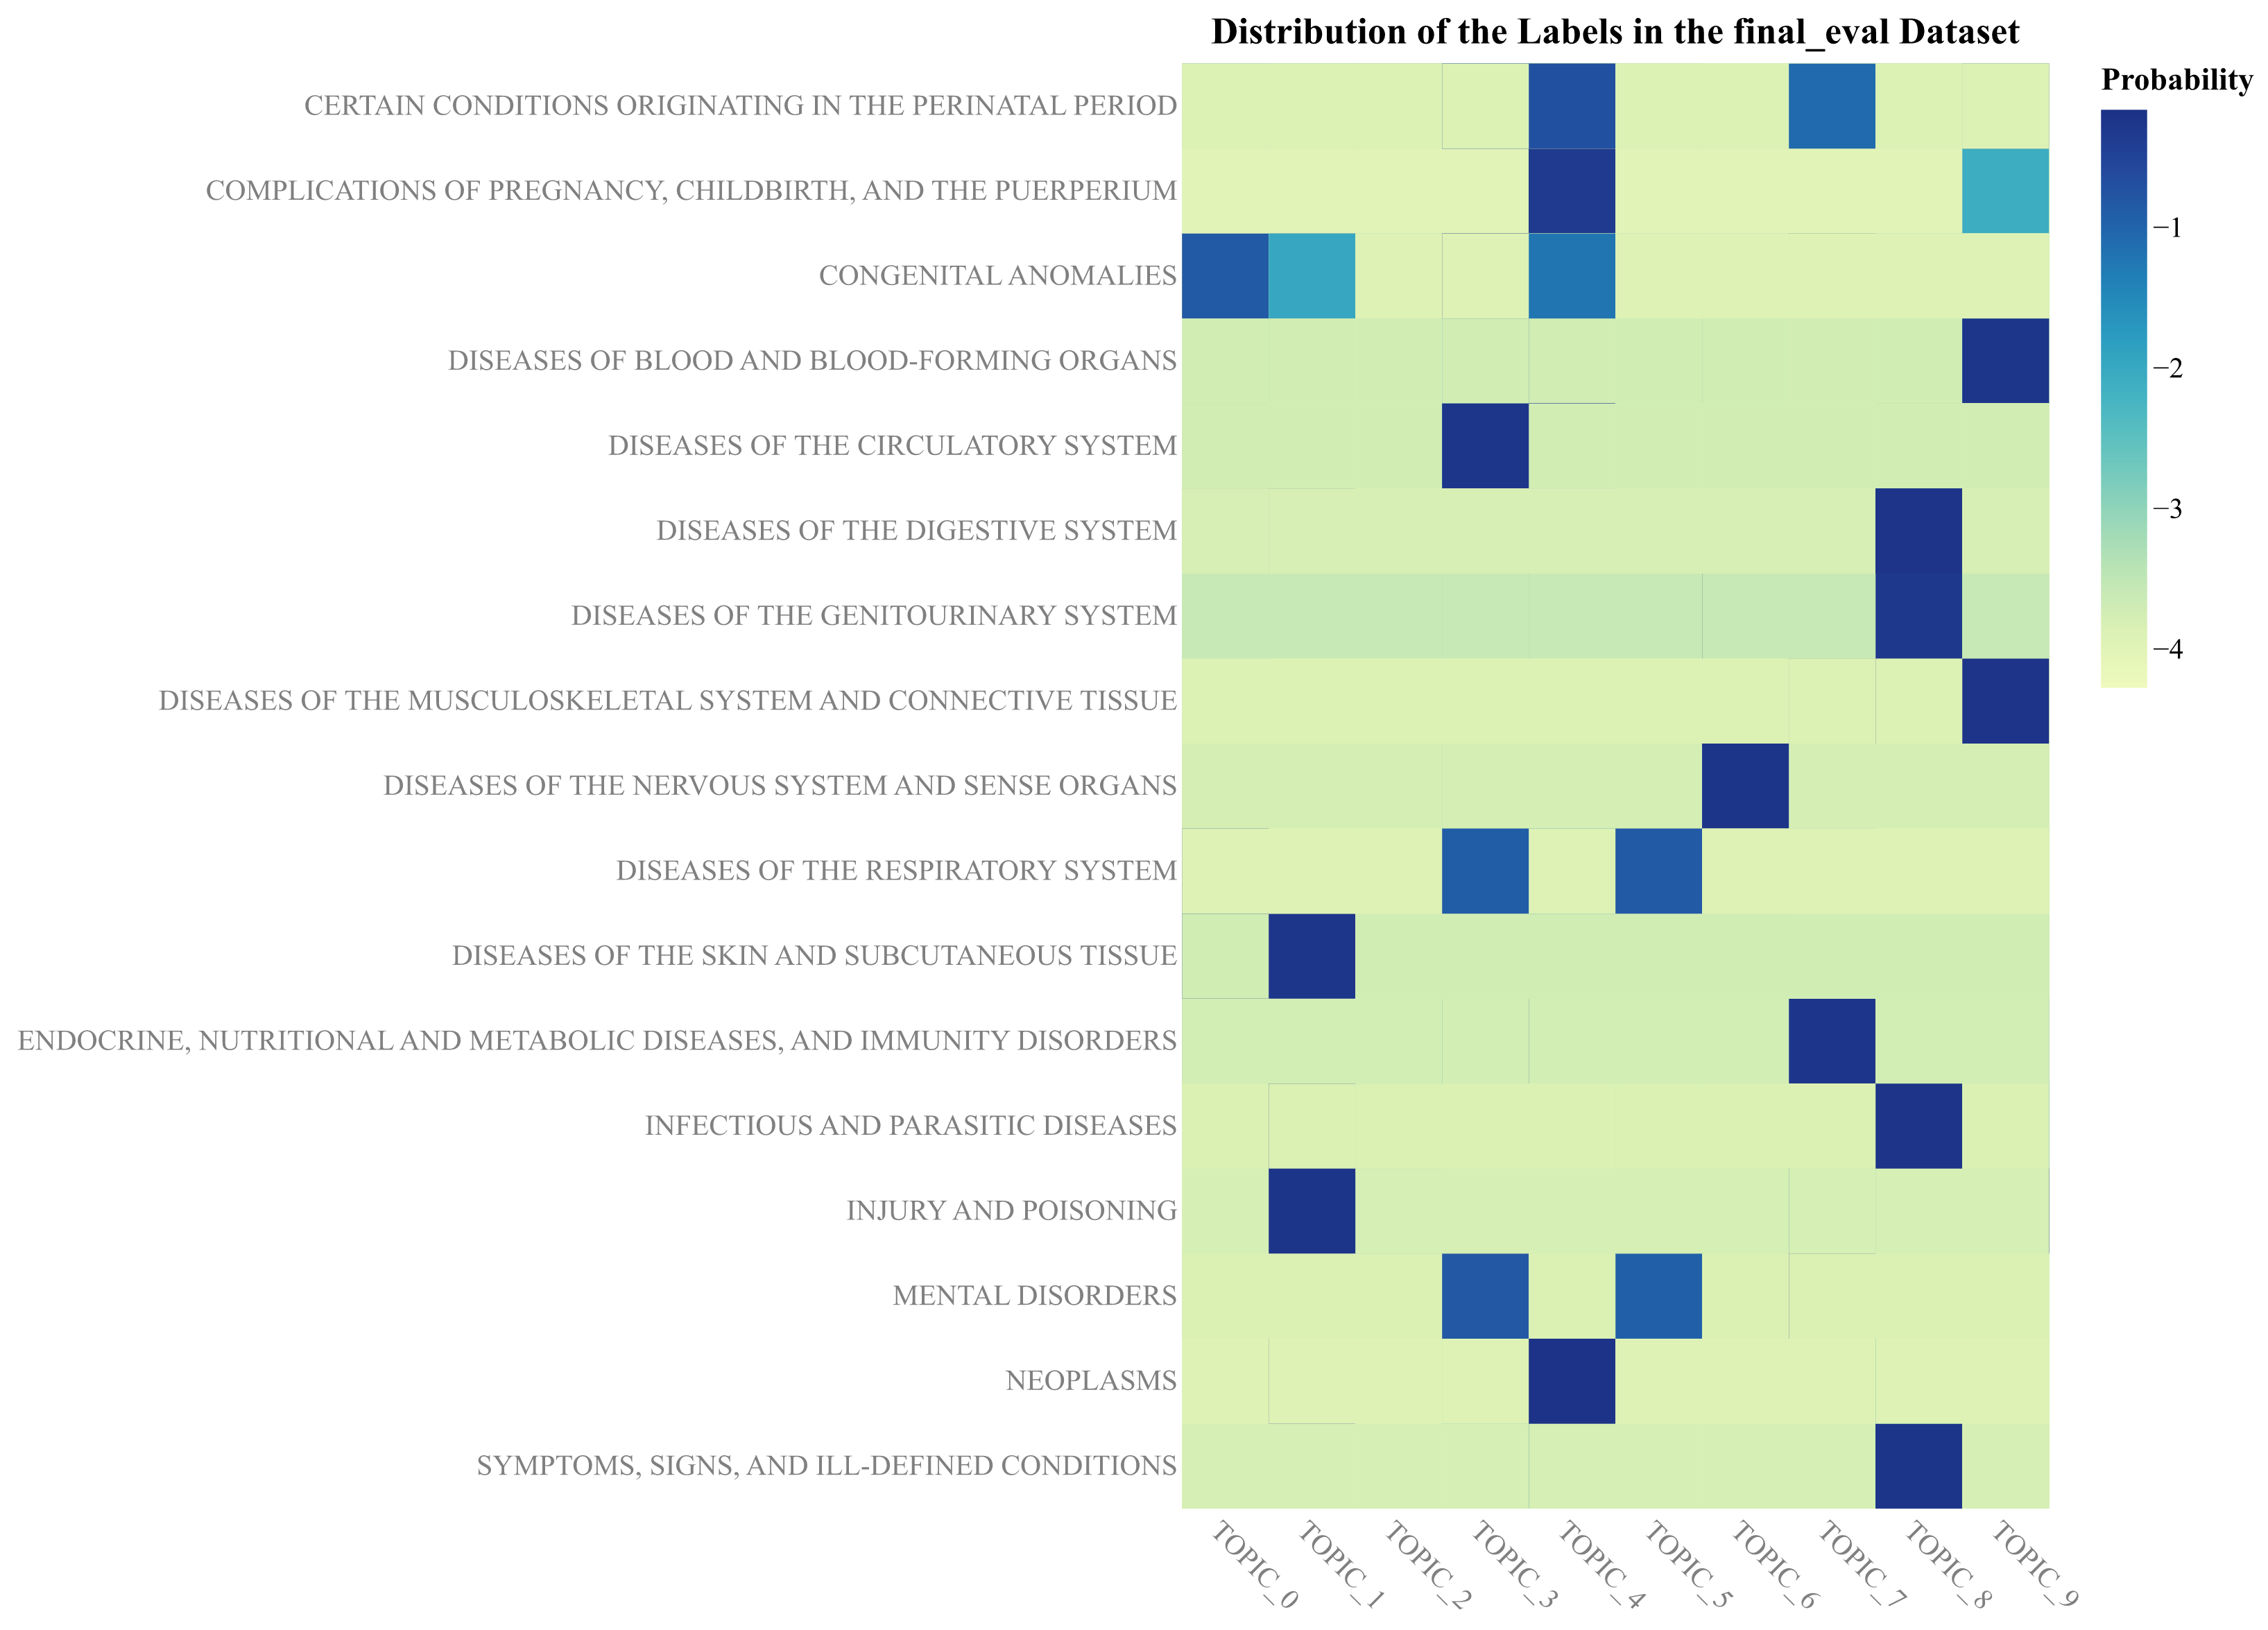

In [13]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'final_eval_topic_distribution_heatmap.png'))

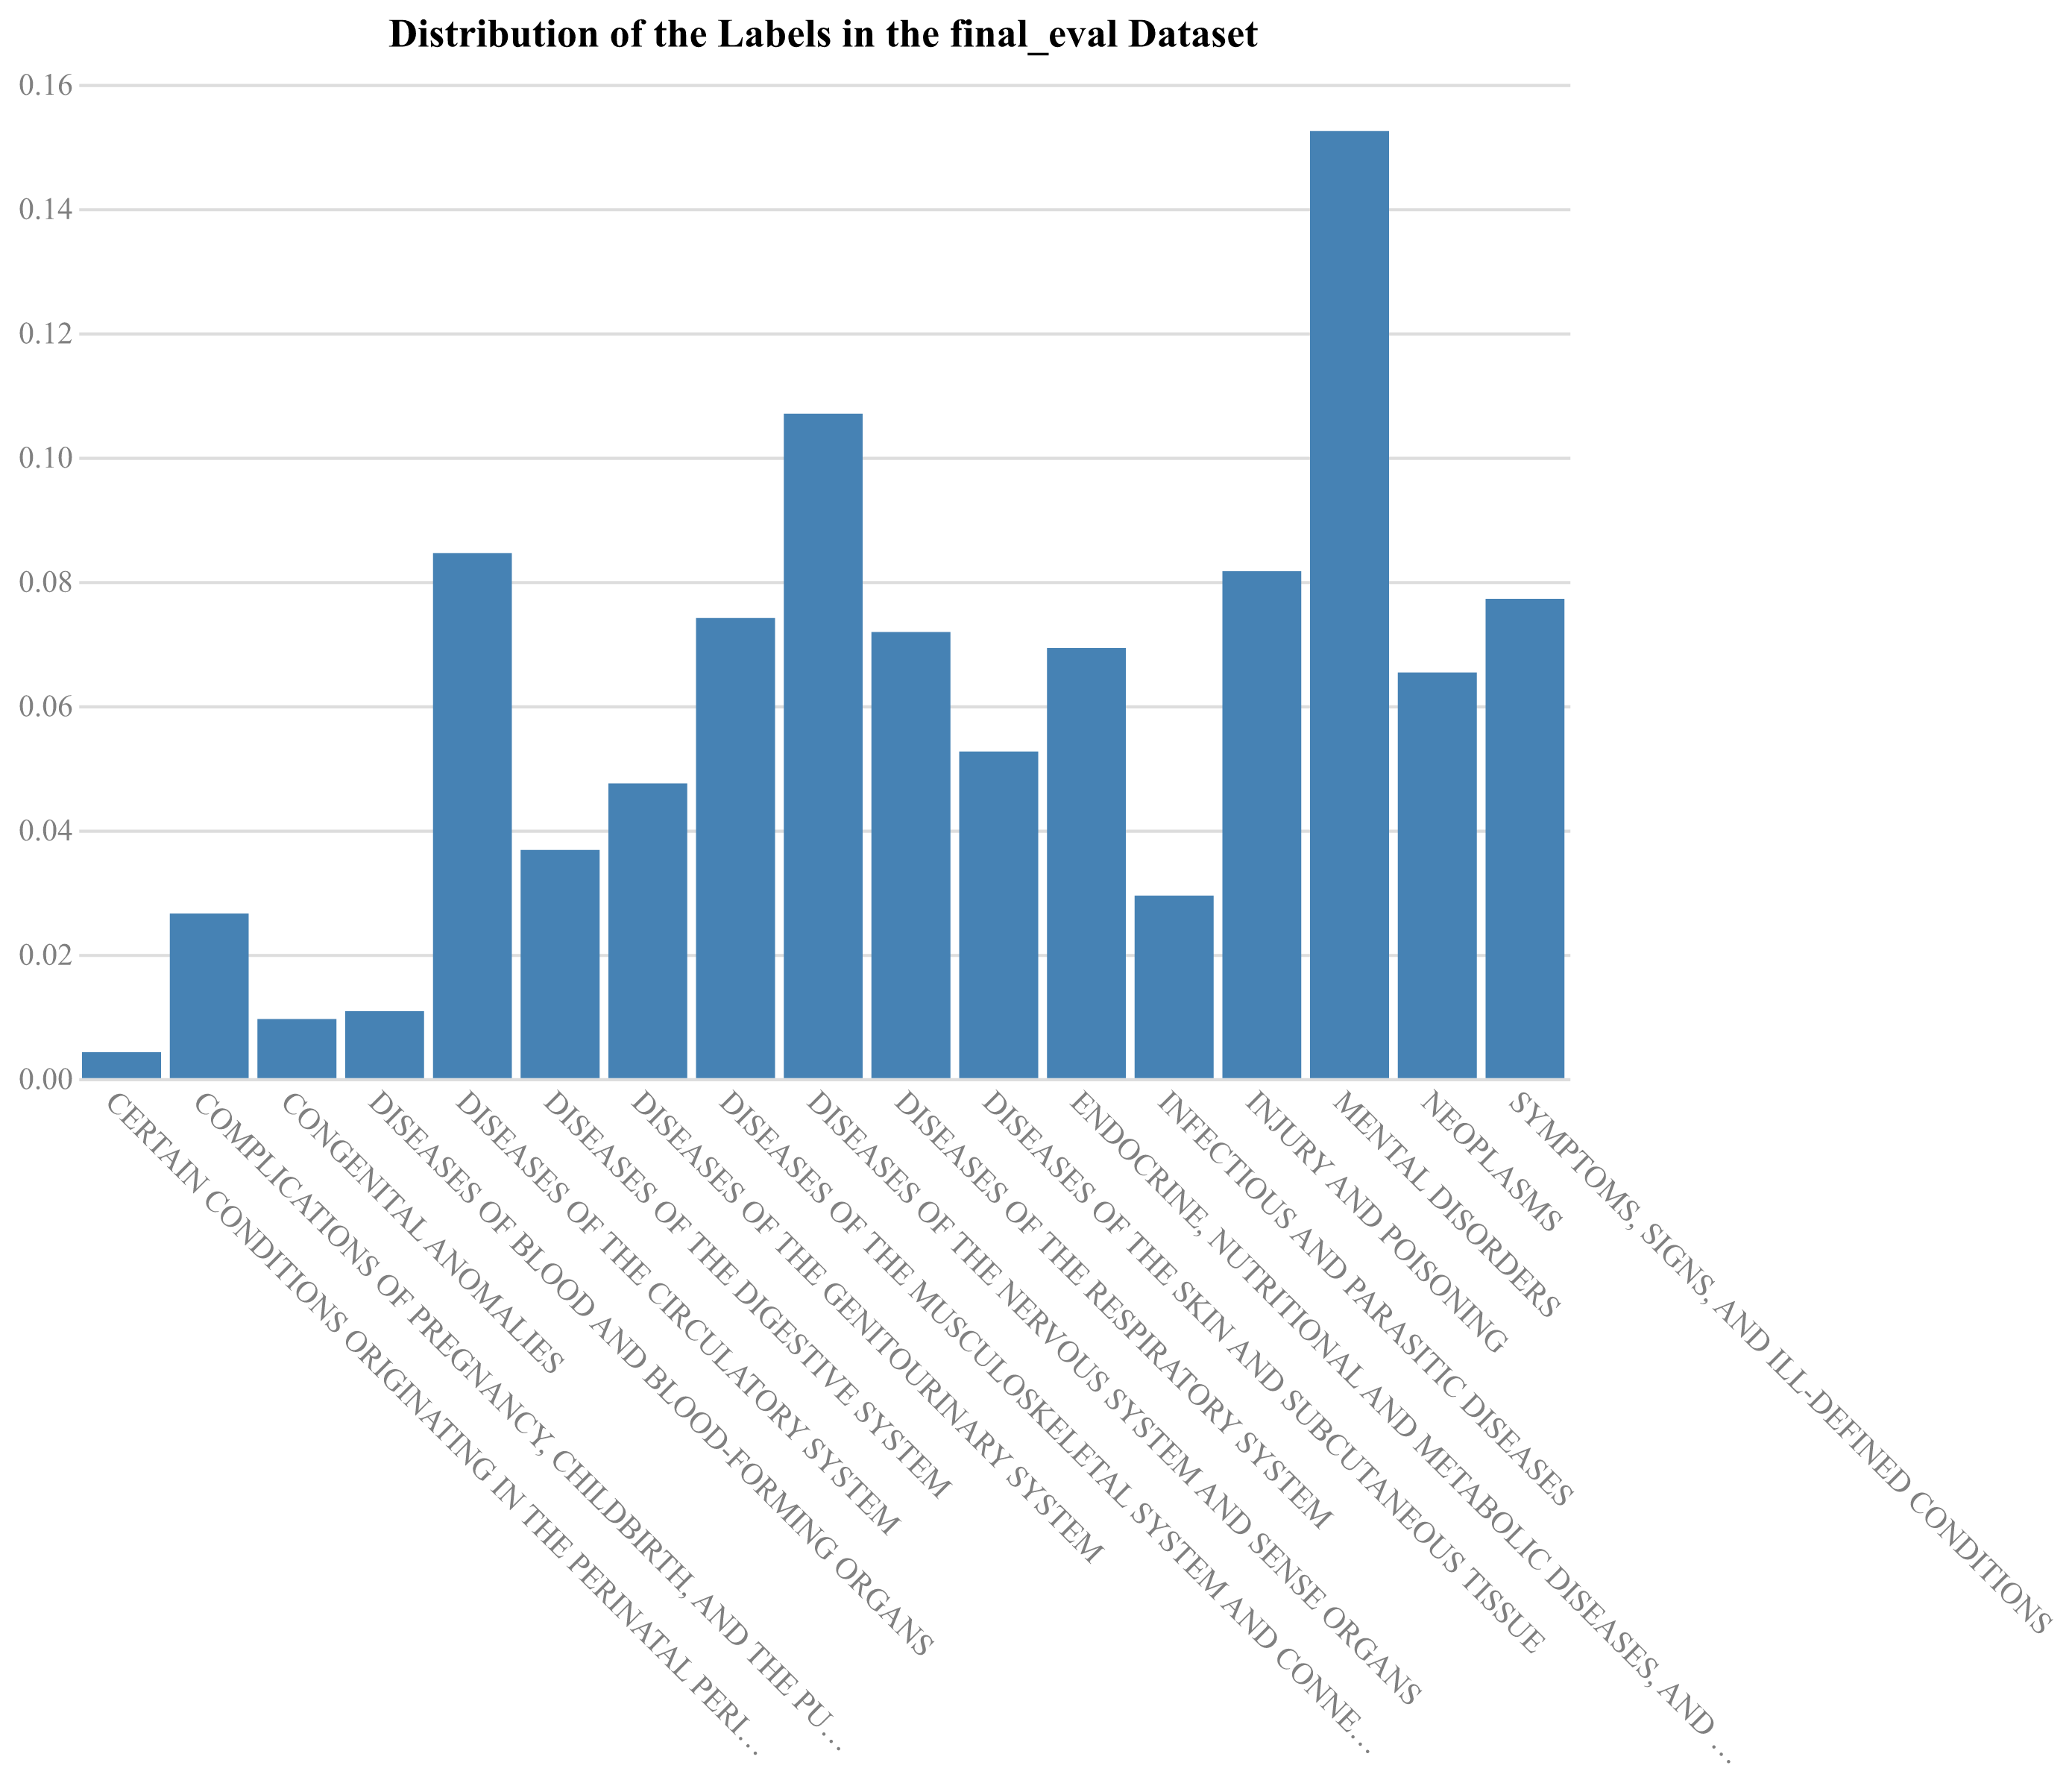

In [14]:
# Load and display the distribution and percentage of the labels
from IPython.display import display
display(Image(filename=os.path.join(figure_path, 'final_eval_label_distribution.png')))

## 3 - Evaluate the best model with the final evaluation dataset

In [18]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class OptionalPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        if self.n_components is not None:
            self.pca.fit(X)
        return self
    
    def transform(self, X):
        if self.n_components is not None:
            return self.pca.transform(X)
        return X

### 3.1 - Reload the saved model

In [19]:
# Load the saved model
halving_search = joblib.load(os.path.join(model_path, f'RandomForestClassifier_halving_search_model.joblib'))

### 3.2 - Prediction and Metrics

In [20]:
y_pred = halving_search.predict(X_eval)

c:\Users\sean7x\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\sean7x\miniconda3\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constan

In [21]:
le = LabelEncoder()
y_eval_encoded = le.fit_transform(y_eval)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_eval_binarized = label_binarize(y_eval_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_eval_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.6651755053553411


In [23]:
accuracy = accuracy_score(y_eval, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_eval, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_eval[y_eval.notna()], y_pred[y_eval.notna()]))

Prediction Accuracy: 0.6442489744398864
Weighted Prediction F1 Score: 0.6337695230073921
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.34      0.66      0.45       106
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.71      0.79      0.75       672
                                                 CONGENITAL ANOMALIES       0.32      0.38      0.35       241
                           DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.46      0.33      0.38       273
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.54      0.57      0.56      2142
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.48      0.54      0.51       931
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.54      0.63      0.58      1203
         DISEASES OF T

### 3.3 - Confusion matrix

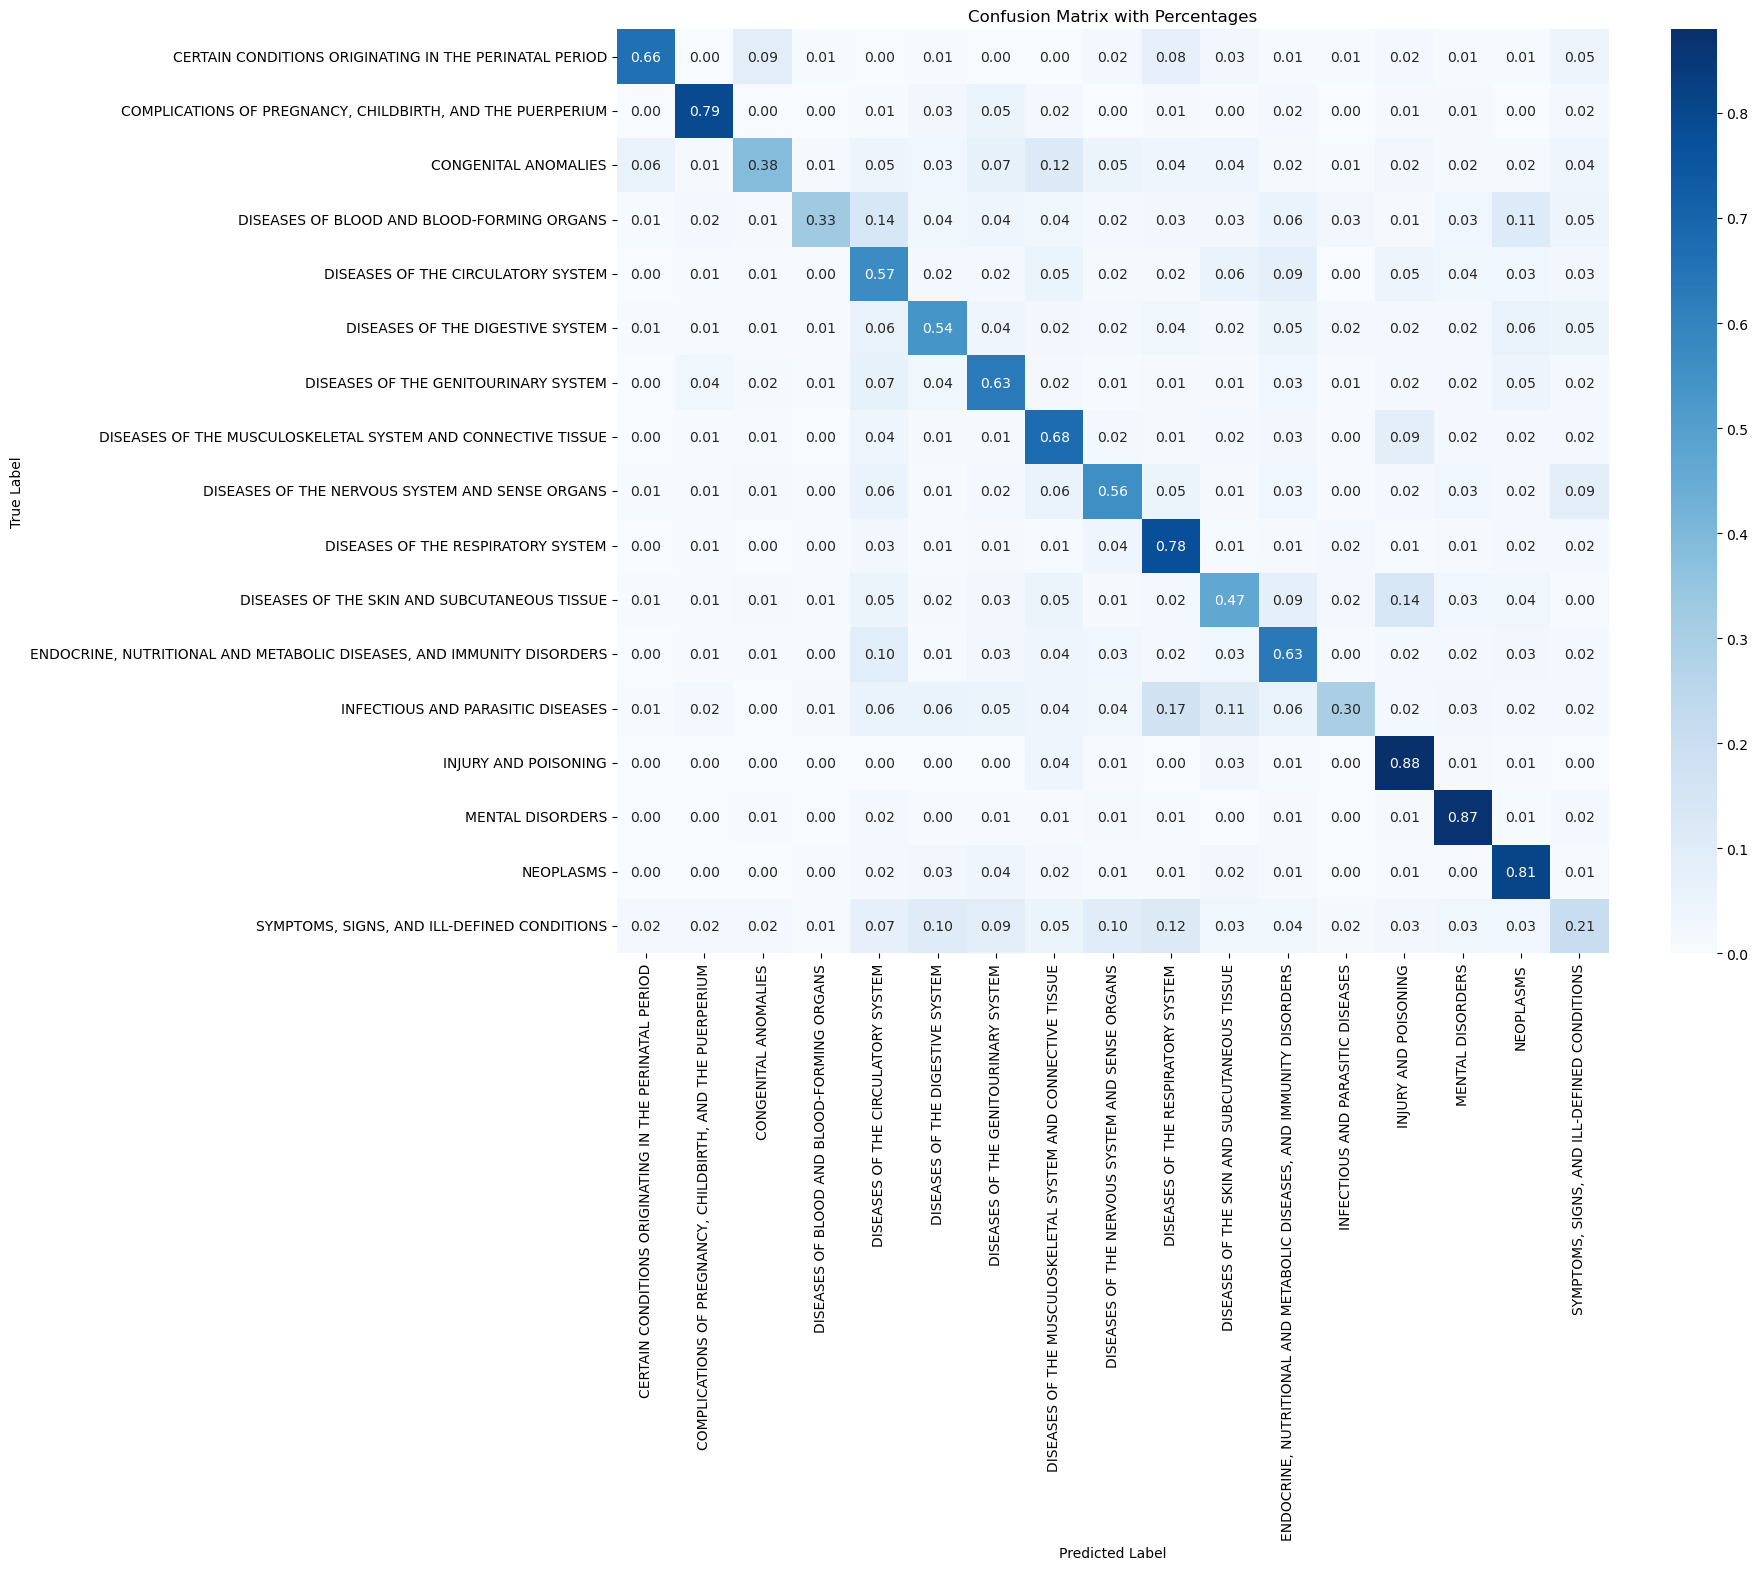

In [24]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_eval, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=halving_search.classes_, yticklabels=halving_search.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## 4 - Retrain the final model with training, validation, test and final evaluation datasets concatenated

### 4.1 - Concatenate training, validation, test and final evaluation datasets

In [25]:
# Concatenate training, validation, test and final evaluation datasets
procd_data = pd.concat([procd_train, procd_val, procd_test, procd_final_eval])

# Define the X_train and y_train
X_train = procd_data.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_data['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (156822, 58)
y Shape: (156822,)


### 4.2 - Refit the final model

In [ ]:
# Refit the final model
best_estimator = halving_search.best_estimator_
#best_estimator.fit(X_train, y_train)

# Save the final model
#joblib.dump(best_estimator, os.path.join(model_path, 'RandomForestClassifier_final_model.joblib'))

In [30]:
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', 'passthrough',
                                                  ['SEX', 'USETOBAC',
                                                   'ARTHRTIS', 'ASTHMA',
                                                   'CANCER', 'CEBVD', 'CHF',
                                                   'CRF', 'COPD', 'DEPRN',
                                                   'DIABETES', 'HYPLIPID',
                                                   'HTN', 'IHD', 'OBESITY',
                                                   'OSTPRSIS']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['INJDET', 'MAJOR', 'RFV1',
                                                   'RFV2', 'RFV3', 'RFV1_MOD1',
                                                   'RFV2_MOD1', 'RFV3_MOD1',
                                                   'RFV1_MOD2', 'RFV2_MOD2',
                                                   'RFV3_MOD2'])])),
                ('scaler', StandardScaler()), ('pca', OptionalPCA()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2',
                                        min_samples_split=10, n_estimators=1000,
                                        n_jobs=-1, random_state=42))])